In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/online-retail-listing/online_retail_listing.csv


# Customer Segmentation and Future Spending Prediction Using RFM Analysis and Random Forest

## Project Objective

The objective is to segment customers using an adapted RFM analysis and predict future spending using a Random Forest model.  
This will allow for a better understanding of customer buying behavior and optimize marketing strategies.


## Dataset Description

The Online Retail dataset contains information about transactions made in an online store, including the following relevant columns:

- InvoiceNo: Invoice number (transaction).  

- StockCode: Product code.

- Description: Product description.

- Quantity: Quantity purchased.

- InvoiceDate: Date of the transaction.

- UnitPrice: Price per unit.

- CustomerID: Customer identification.

- Country: Customer's country.


## Data Processing

### 1. Data Cleaning:

- First, we need to load the dataset and clean it by removing any invalid transactions:



In [2]:
# Load the dataset with ISO-8859-1 encoding and semicolon separator
data_path = '/kaggle/input/online-retail-listing/online_retail_listing.csv'
data = pd.read_csv(data_path, sep=';', encoding='ISO-8859-1', on_bad_lines='warn')

# Check the columns in the DataFrame
print("Columns in the dataset:", data.columns)

# Strip any whitespace from the column names
data.columns = data.columns.str.strip()

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Remove transactions without a Customer ID
data.dropna(subset=['Customer ID'], inplace=True)

# Convert 'Quantity' and 'Price' to numeric, coercing errors to NaN
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# Remove rows with NaN values in 'Quantity' or 'Price' after the conversion
data.dropna(subset=['Quantity', 'Price'], inplace=True)

# Now remove transactions with negative values in 'Quantity' and 'Price'
data = data[(data['Quantity'] > 0) & (data['Price'] > 0)]

# Display the shape of the cleaned dataset
print(f"Cleaned dataset shape: {data.shape}")


Columns in the dataset: Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

       InvoiceDate Price  Customer ID         Country  
0  1.12.2009 07:45  6,95      13085.0  United Kingdom  
1  1.12.2009 07:45  6,75      13085.0  United Kingdom  
2  1.12.2009 07:45  6,75      13085.0  United Kingdom  
3  1.12.2009 07:45   2,1      13085.0  United Kingdom  
4  1.12.2009 07:45  1,25      13085.0  United Kingdom  
Cleaned dataset shape: (2830, 8)


### 2. Calculate RFM:

Next, we will calculate Recency, Frequency, and Monetary Value:  


In [3]:
# Convert 'InvoiceDate' to datetime, specifying dayfirst=True
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], dayfirst=True, errors='coerce')

# Check for any parsing issues (e.g., rows where InvoiceDate is NaT due to invalid format)
invalid_dates = data[data['InvoiceDate'].isna()]
print(f"Number of rows with invalid dates: {len(invalid_dates)}")

# Optionally, remove rows with invalid dates
data.dropna(subset=['InvoiceDate'], inplace=True)

# Create a snapshot date (latest date in the dataset)
snapshot_date = data['InvoiceDate'].max() + pd.DateOffset(days=1)

# Calculate RFM metrics
rfm = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'count',                                      # Frequency
    'Quantity': 'sum',                                        # Total Quantity
    'Price': 'mean'                                           # Average Price
}).rename(columns={'InvoiceDate': 'Recency', 
                   'Invoice': 'Frequency', 
                   'Quantity': 'MonetaryValue'})

# Calculate Monetary Value as Quantity * Average Price
rfm['MonetaryValue'] = rfm['MonetaryValue'] * (data.groupby('Customer ID')['Price'].mean())

# Display the first few rows of the RFM DataFrame
rfm.head()



Number of rows with invalid dates: 0


,Recency,Frequency,MonetaryValue,Price
Customer ID,,,,
12346.0,717,1,1.0,1.0
12348.0,70,5,322.0,32.2
12349.0,14,3,750.0,250.0
12350.0,305,1,40.0,40.0
12352.0,31,5,280.0,40.0


##  RFM Scoring
Instead of dividing by quartiles, we can categorize Recency, Frequency, and MonetaryValue using custom ranges adapted to the specific data distribution:

In [4]:
# Create categories based on the distribution (specifying custom limits)
def categorize_recency(recency):
    if recency <= 30:
        return 5  # Very recent
    elif recency <= 90:
        return 4
    elif recency <= 180:
        return 3
    elif recency <= 365:
        return 2
    else:
        return 1  # Long time ago

def categorize_frequency(frequency):
    if frequency >= 50:
        return 5  # Frequent purchases
    elif frequency >= 20:
        return 4
    elif frequency >= 10:
        return 3
    elif frequency >= 5:
        return 2
    else:
        return 1  # Few purchases

def categorize_monetary(monetary):
    if monetary >= 1000:
        return 5  # High spenders
    elif monetary >= 500:
        return 4
    elif monetary >= 200:
        return 3
    elif monetary >= 100:
        return 2
    else:
        return 1  # Low spenders

# Apply the functions to the corresponding columns
rfm['Recency_score'] = rfm['Recency'].apply(categorize_recency)
rfm['Frequency_score'] = rfm['Frequency'].apply(categorize_frequency)
rfm['Monetary_score'] = rfm['MonetaryValue'].apply(categorize_monetary)

# Create a combined score
rfm['RFM_Score'] = rfm['Recency_score'].map(str) + rfm['Frequency_score'].map(str) + rfm['Monetary_score'].map(str)

# Define Customer Segments
def segment_customers(row):
    # Define the categories based on new rules
    if row['Recency_score'] >= 4 and row['Frequency_score'] >= 4 and row['Monetary_score'] >= 4:
        return 'Top Clients'
    elif row['Recency_score'] >= 3 and row['Frequency_score'] >= 3 and row['Monetary_score'] >= 3:
        return 'Loyal Spenders'
    elif row['Recency_score'] <= 2 and row['Frequency_score'] <= 2 and row['Monetary_score'] <= 2:
        return 'Low Activity'
    else:
        return 'Potential'

# Apply the function to segment customers
rfm['CustomerSegment'] = rfm.apply(segment_customers, axis=1)

# Count the number of customers in each segment
segment_counts = rfm['CustomerSegment'].value_counts()


### Bar Plot of Customer Segments

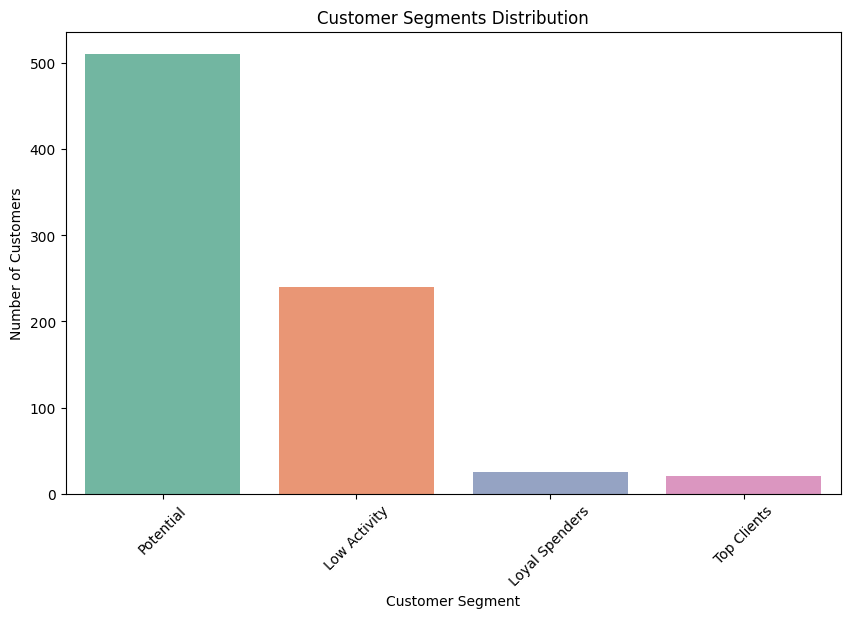

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='Set2')
plt.title('Customer Segments Distribution')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


 ### Scatter Plot of Recency vs. Monetary Value by Segment

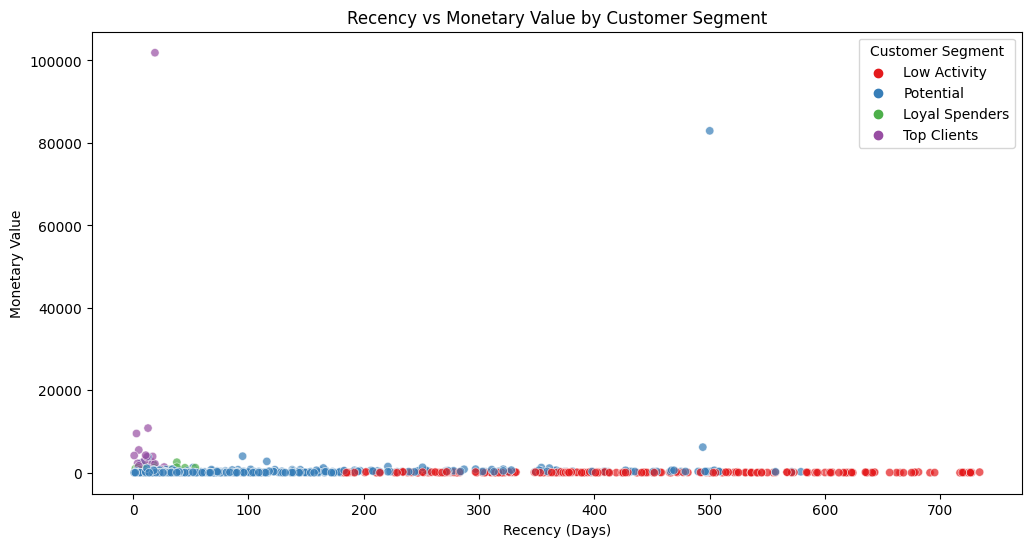

In [6]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm, x='Recency', y='MonetaryValue', hue='CustomerSegment', palette='Set1', alpha=0.7)
plt.title('Recency vs Monetary Value by Customer Segment')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary Value')
plt.legend(title='Customer Segment')
plt.show()


### Box Plot for Recency and Monetary Value by Segment

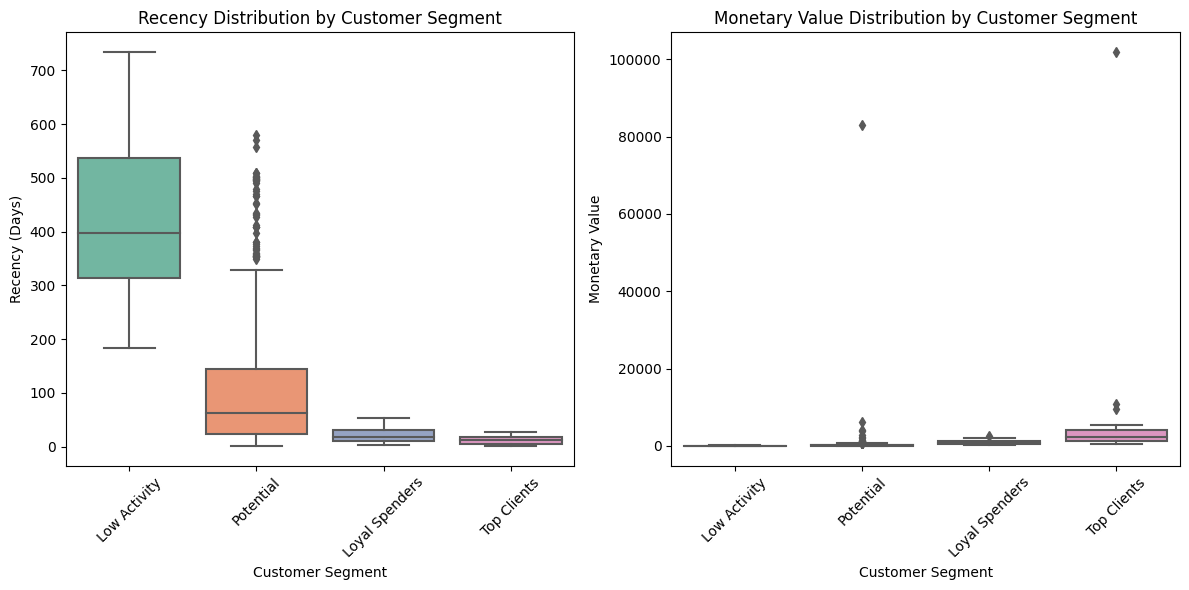

In [7]:
plt.figure(figsize=(12, 6))

# Boxplot for Recency
plt.subplot(1, 2, 1)
sns.boxplot(data=rfm, x='CustomerSegment', y='Recency', palette='Set2')
plt.title('Recency Distribution by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Recency (Days)')
plt.xticks(rotation=45)

# Boxplot for Monetary Value
plt.subplot(1, 2, 2)
sns.boxplot(data=rfm, x='CustomerSegment', y='MonetaryValue', palette='Set2')
plt.title('Monetary Value Distribution by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Monetary Value')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Random Forest Model for Future Spending Prediction
The goal here is to predict future spending based on historical data.  
We will use the Random Forest algorithm for this task.

### Feature Engineering

In [8]:
# Prepare features and target variable
features = rfm[['Recency', 'Frequency', 'MonetaryValue']]
target = rfm['MonetaryValue']  # Future spending (you may want to define this differently)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


### Model Training

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Instantiate the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")


Mean Squared Error: 233.76
R-squared: 1.00


## Model Evaluation

### Feature Importance in Random Forest

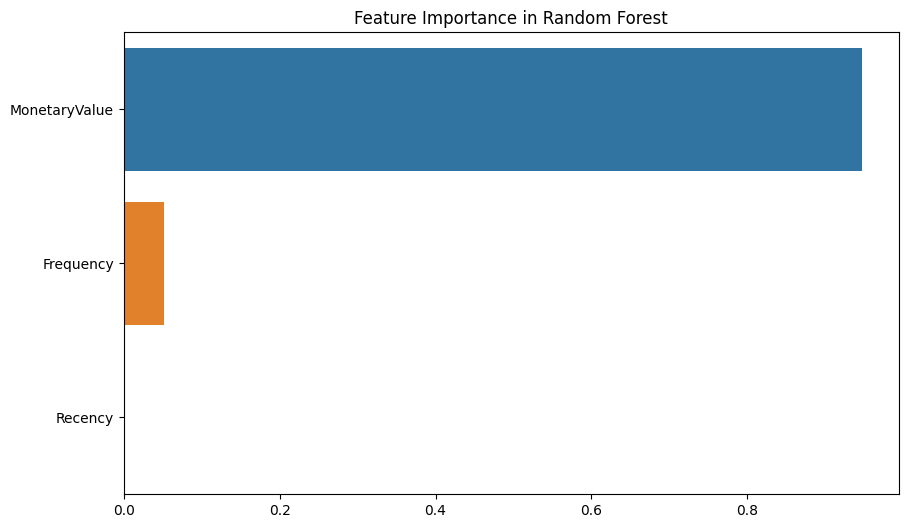

In [10]:
# Feature importance
importances = rf_model.feature_importances_
feature_names = features.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title('Feature Importance in Random Forest')
plt.show()


### Predictions vs. Actual Values Plot

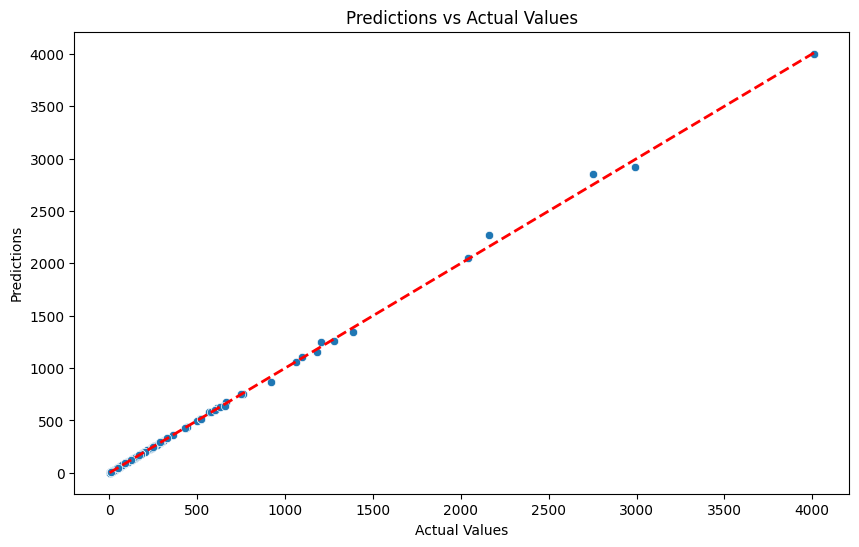

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.show()


### Customer Segment Analysis

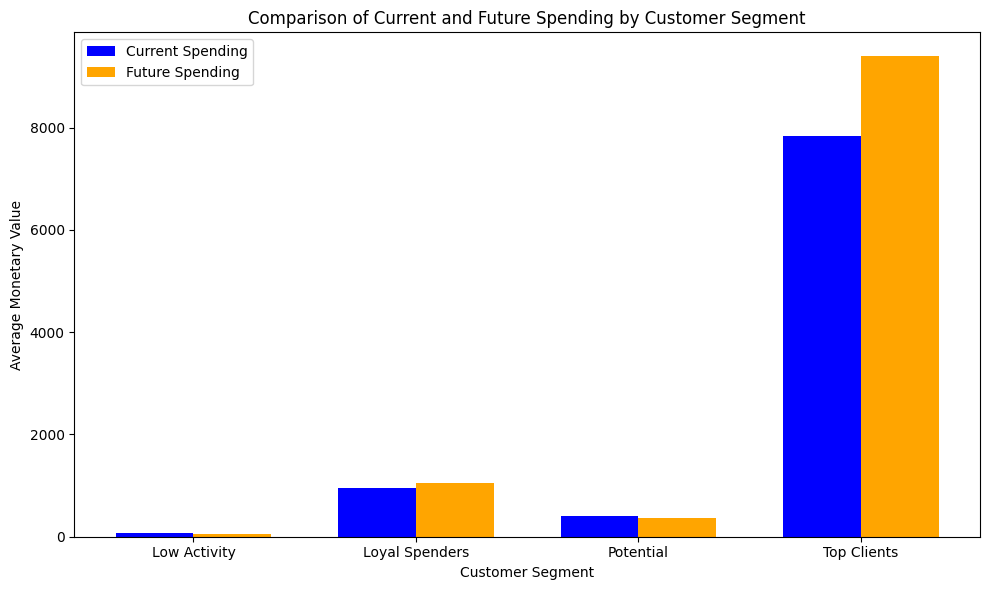

In [12]:
# Define the function to calculate future spending
def calculate_future_spending(row):
    base_spending = row['MonetaryValue']
    segment = row['CustomerSegment']
    
    if segment == 'Top Clients':
        return base_spending * 1.2  # Expecting higher spending
    elif segment == 'Loyal Spenders':
        return base_spending * 1.1  # Slightly higher spending
    elif segment == 'Potential':
        return base_spending * 0.9   # Slightly lower spending
    else:  # Low Activity
        return base_spending * 0.8   # Significantly lower spending

# Apply the function to calculate future spending
rfm['FutureSpending'] = rfm.apply(calculate_future_spending, axis=1)

# Summarize the data for the chart
summary = rfm.groupby('CustomerSegment')[['MonetaryValue', 'FutureSpending']].mean().reset_index()

# Configure the chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(summary))

# Bar chart for Current Monetary Spending
plt.bar(index, summary['MonetaryValue'], bar_width, label='Current Spending', color='b')

# Bar chart for Future Spending
plt.bar([i + bar_width for i in index], summary['FutureSpending'], bar_width, label='Future Spending', color='orange')

# Add labels and title
plt.xlabel('Customer Segment')
plt.ylabel('Average Monetary Value')
plt.title('Comparison of Current and Future Spending by Customer Segment')
plt.xticks([i + bar_width / 2 for i in index], summary['CustomerSegment'])
plt.legend()

# Show the chart
plt.tight_layout()
plt.show()

## Analysis of Results and Customer Segments

### - Low Activity:

  Strategy: Reactivation through email campaigns with personalized discounts.

### - Loyal Spenders:

  Strategy: Enhance loyalty programs and offer exclusive access to products.

### - Top Clients:

  Strategy: Provide personalized experiences and create VIP programs.

### - Potential:

  Strategy: Upselling and cross-selling strategies, along with soliciting feedback.


## Conclusions

The implementation of RFM and the Random Forest model has enabled customer segmentation and prediction of future spending. Despite challenges in model performance, segmentation provides tailored marketing strategies that can enhance customer retention and optimize advertising spend. To improve model accuracy, exploring additional techniques and tuning hyperparameters is recommended.